In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
!pip install qiskit ipywidgets # while working on google colab!

In [ ]:
# while working on google colab, run this cell
!wget https://raw.githubusercontent.com/neelkanthrawat/QBM_sept2022/main/qbm_codes/qbm_utils.py

In [5]:
from qbm_utils import *

In [6]:
# define the model
## put n_spins even always
n_spins = 4

## construct problem Hamiltonian ##
shape_of_J=(n_spins,n_spins)
J =  np.random.randn(n_spins,n_spins)#np.random.uniform(low= -1, high= 1, size= (n_spins, n_spins) )
J = 0.5 * (J + J.transpose() )
h = np.random.randn(n_spins)#np.random.uniform(low= -1, high = 1, size= (n_spins))

# instantiate the model
model = IsingEnergyFunction(J, h)

alpha = np.sqrt(n_spins) / np.sqrt( sum([J[i][j]**2 for i in range(n_spins) for j in range(i)]) + sum([h[j]**2 for j in range(n_spins)])  )


## Some updated funcs

In [7]:
def classical_mcmc(N_hops:int, num_spins:int, num_elems:int, model, return_last_n_states=500, return_both_classical_and_quantum_steps=False ):
    ''' 
    version 0.2
    Args: 
    Nhops: Number of time you want to run mcmc
    num_spins: number of spins
    num_elems: 2**(num_spins)
    model

    Returns:
    Last 'return_last_n_states' elements of states so collected (default value=500). one can then deduce the distribution from it! 
    '''
    states=[]
    current_state=f'{np.random.randint(0,num_elems):0{num_spins}b}'# bin_next_state=f'{next_state:0{num_spins}b}'
    print("starting with: ", current_state) 

    ## initialiiise observables
    #observable_dict = dict([ (elem, []) for elem in observables ])
    list_after_transition=[]
    list_after_acceptance_step=[]

    for i in tqdm(range(0, N_hops)):
        states.append(current_state)
        # get sprime
        s_prime=classical_transition(num_spins)
        list_after_transition.append(s_prime)
        # accept/reject s_prime 
        energy_s=model.get_energy(current_state)
        energy_sprime=model.get_energy(s_prime)
        next_state= classical_loop_accepting_state(current_state, s_prime, energy_s, energy_sprime,temp=1)
        current_state= next_state
        list_after_acceptance_step.append(current_state)
        # if store_observables:  ## store the observables 
          
        #   if next_state == s_prime: observable_dict['acceptance'].append('True')
        #   else: observable_dict['acceptance'].append('False')
        #   observable_dict['energy'].append(model.get_energy(next_state))

        ## reinitiate
        qc_s=initialise_qc(n_spins=num_spins, bitstring=current_state)
    
    # returns dictionary of occurences for last "return_last_n_states" states
    dict_count_return_last_n_states=Counter(states[-return_last_n_states:])
    
    if return_both_classical_and_quantum_steps: 
        to_return = dict_count_return_last_n_states, list_after_transition, list_after_acceptance_step
    else: 
        to_return= dict_count_return_last_n_states 
    
    return to_return

In [8]:
def quantum_enhanced_mcmc(N_hops:int, num_spins:int, num_elems:int, model:IsingEnergyFunction, alpha, num_trotter_steps=10, return_last_n_states=500, return_both_classical_and_quantum_steps=False):
    ''' 
    version 0.2
    Args: 
    Nhops: Number of time you want to run mcmc
    num_spins: number of spins
    num_elems: 2**(num_spins)

    Returns:
    Last 'return_last_n_states' elements of states so collected (default value=500). one can then deduce the distribution from it! 
    '''
    states=[]
    current_state=f'{np.random.randint(0,num_elems):0{num_spins}b}'# bin_next_state=f'{next_state:0{num_spins}b}'
    print("starting with: ", current_state) 
    ## initialise quantum circuit to current_state
    qc_s=initialise_qc(n_spins=num_spins, bitstring=current_state)
    #print("qc_s is:"); print(qc_s.draw())

    ## intialise observables
    #observable_dict = dict([ ( elem, []  ) for elem in observables ])
    list_after_transition=[]
    list_after_acceptance_step=[]

    for i in tqdm(range(0, N_hops)):
        #print("i: ", i)
        states.append(current_state)
        # get sprime
        s_prime=run_qc_quantum_step(qc_initialised_to_s=qc_s, model= model, alpha=alpha, n_spins=num_spins, num_trotter_steps=num_trotter_steps, time=0.8)
        list_after_transition.append(s_prime)
        # accept/reject s_prime 
        energy_s=model.get_energy(current_state)
        energy_sprime=model.get_energy(s_prime)
        next_state= classical_loop_accepting_state(current_state, s_prime, energy_s, energy_sprime,temp=1)
        current_state=next_state
        # if current_state!=next_state:# this seems to be a redundant step. I could have set current_state=classical_loop_accepting_state(current_state, s_prime, energy_s, energy_sprime,temp=1)
        #   current_state= next_state
        list_after_acceptance_step.append(current_state)

        # if store_observables:  ## store the observables 
          
        #   if next_state == s_prime: observable_dict['acceptance'].append('True')
        #   else: observable_dict['acceptance'].append('False')
        #   observable_dict['energy'].append(model.get_energy(next_state))

        ## reinitiate
        qc_s=initialise_qc(n_spins=num_spins, bitstring=current_state)
      
    dict_count_return_last_n_states=Counter(states[-return_last_n_states:])#dictionary of occurences for last "return_last_n_states" states

    if return_both_classical_and_quantum_steps: 
      to_return= dict_count_return_last_n_states, list_after_transition, list_after_acceptance_step
    else: 
      to_return= dict_count_return_last_n_states

    return to_return

In [9]:
def states(num_spins:int)->str:
    num_possible_states=2**(num_spins)
    possible_states=[f'{k:0{num_spins}b}' for k in range(0,num_possible_states)]
    return possible_states

def magnetization_of_state(bitstring:str)->float:
    array=np.array(list(bitstring))
    num_times_one=np.count_nonzero(array=='1')
    num_times_zero=len(array)-num_times_one
    magnetization=num_times_one-num_times_zero
    return magnetization

def dict_magnetization_of_all_states(list_all_possible_states:list)->dict:
    list_mag_vals=[magnetization_of_state(state) for state in list_all_possible_states]
    dict_magnetization=dict(zip(list_all_possible_states, list_mag_vals ))
    print("dict_magnetization:"); print(dict_magnetization)
    return dict_magnetization

## Run classical MCMC

In [11]:
states_nbit=states(num_spins=4)
dict_mag=dict_magnetization_of_all_states(states_nbit)

dict_magnetization:
{'0000': -4, '0001': -2, '0010': -2, '0011': 0, '0100': -2, '0101': 0, '0110': 0, '0111': 2, '1000': -2, '1001': 0, '1010': 0, '1011': 2, '1100': 0, '1101': 2, '1110': 2, '1111': 4}


starting with:  0001


100%|██████████| 1000/1000 [00:00<00:00, 4516.29it/s]


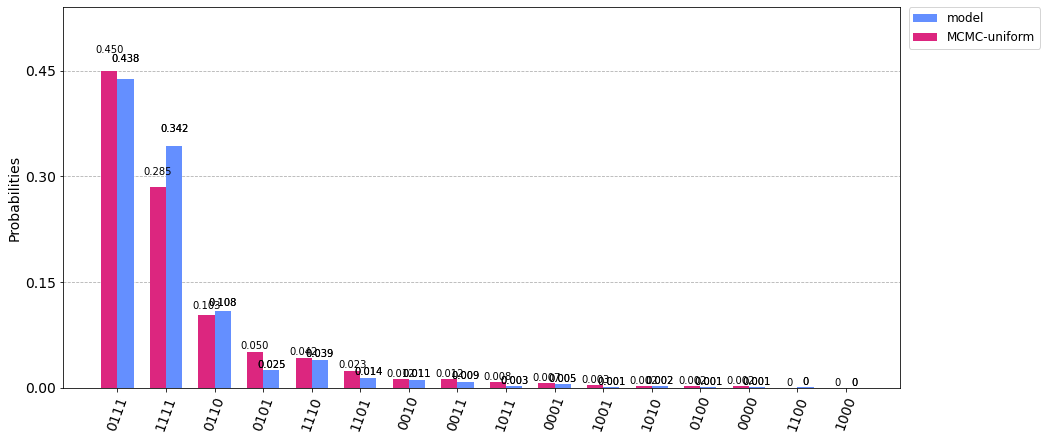

In [39]:
# symmetric uniform transition matrix for uniform transition rule
num_spins=4
num_elems=2**(num_spins)
transit_mat=np.ones((num_elems,num_elems))*(1./(2*num_elems))# in general case transit matrix could be entirely different
np.fill_diagonal(transit_mat, 1./2)

# Run MCMC with uniform random transition strategy
N_hops=1000
dict_states_mcmc, cl_mcmc_after_trsn, cl_mcmc_after_accept =classical_mcmc(N_hops, num_spins, num_elems,model, return_last_n_states=600, return_both_classical_and_quantum_steps=True)

# get actual probability distribution
transits_bltz = dict( [ ( state, model.get_boltzmann_prob(state) ) for state in states_nbit ] )
# plot actual prob distribution as well as one obtained from MCMC
plot_histogram( [transits_bltz, dict_states_mcmc] , figsize=(15, 7), legend= ['model', 'MCMC-uniform'], sort="value_desc")

## Run quantum enhanced MCMC

In [35]:
# symmetric uniform transition matrix for uniform transition rule: tho tbh I dont need it
num_spins=4
num_elems=2**(num_spins)
transit_mat=np.ones((num_elems,num_elems))*(1./(2*num_elems))# in general case transit matrix could be entirely different
np.fill_diagonal(transit_mat, 1./2)

# Run MCMC with uniform random transition strategy
N_hops=1000
dict_states_quantum_mcmc, quant_mcmc_after_trsn, quant_mcmc_after_accept =quantum_enhanced_mcmc(N_hops, 
num_spins, num_elems, model, alpha, num_trotter_steps=10, 
return_last_n_states=600,return_both_classical_and_quantum_steps=True)

# get actual probability distribution
transits_bltz = dict( [ ( state, model.get_boltzmann_prob(state) ) for state in states_nbit ] )
# plot actual prob distribution as well as one obtained from MCMC
#plot_histogram( [transits_bltz, dict_states_quantum_mcmc] , figsize=(15, 7), legend= ['model', 'Quantum-enhanced MCMC' ])#, sort= 'value_desc')

starting with:  1111


100%|██████████| 1000/1000 [03:50<00:00,  4.34it/s]


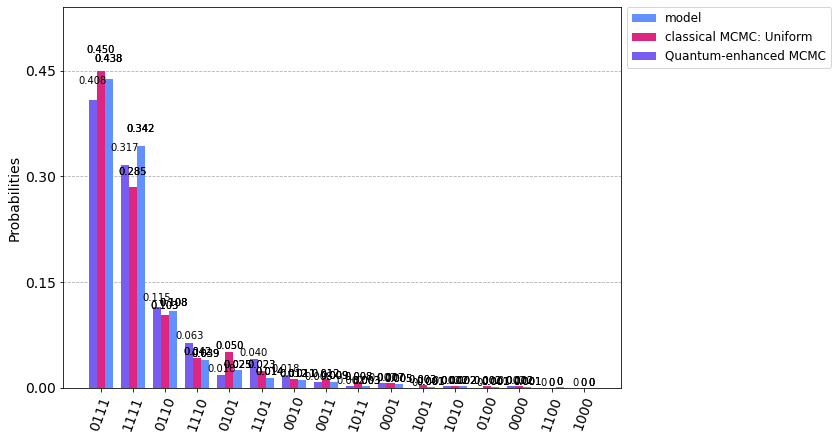

In [40]:
plot_histogram( [transits_bltz,dict_states_mcmc, dict_states_quantum_mcmc] , figsize=(10, 7), legend= ['model', 'classical MCMC: Uniform','Quantum-enhanced MCMC' ], sort='value_desc')

### comparing number of accpeted/rejected samples

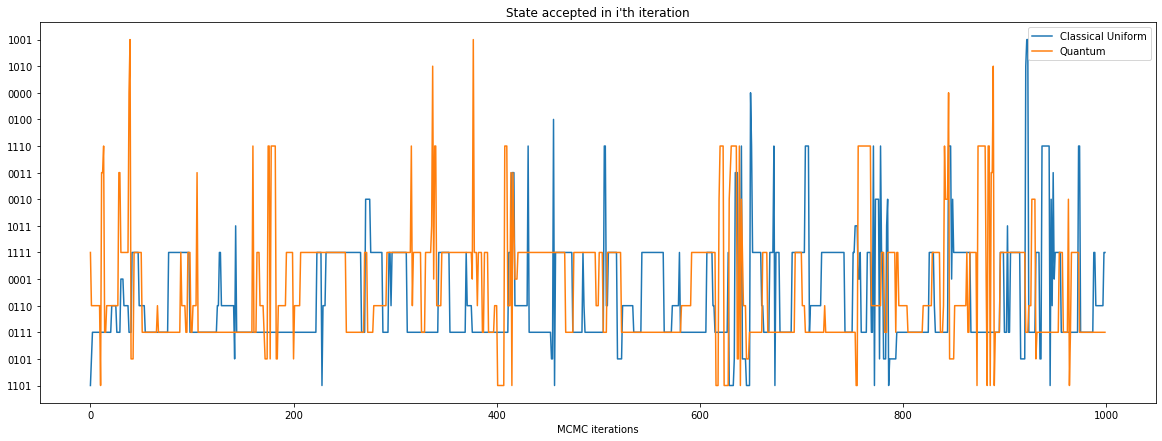

In [41]:
# plt.figure(figsize=(20,7))
# plt.plot(cl_mcmc_after_trsn, label="Classical Uniform")
# plt.plot(quant_mcmc_after_trsn, label="Quantum")
# plt.xlabel("MCMC iterations")
# plt.title("after transition")
plt.figure(figsize=(20,7))
#quant_mcmc_after_trsn, quant_mcmc_after_accept
plt.plot(cl_mcmc_after_accept, label="Classical Uniform")
plt.plot(quant_mcmc_after_accept,label="Quantum")
plt.xlabel("MCMC iterations")
plt.title("State accepted in i'th iteration")
plt.legend()

Next task:
For different problem instances, do the following:

1. Running average of expectation value of magnetization.

2.  For first few relevant states (high probability), check how many times were those states accepted/rejected out of total number of iterations considered for the prob distn.

3. Overlap with the desired distribution.
